<a href="https://colab.research.google.com/github/guillelencina/Trabajo_final_seminario/blob/master/red_spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabajo seminario final

En este trabajo se pretende dejar una herramienta para abordar la relaciones que existen entre diferentes usuarios de spotify a partir de analizar los artistas que comparten y de algún modo las similitudes en sus gustos musicales. Este estudio podría ser el puntapie de un sistema de recomendación. 


El abordaje plantea tres enfoques diferentes complementarios:

    1_ Crear una "mapa de calor" que muestre cuánto matchean, en artistas, dos usuarios.  
    2_ Utilizar un algoritmo de clustering para visualizar grupos de usuarios con gustos similares.
    3_ Realizar un grafo del grupo de usuarios en estudio para analizar que tan interconectada es la red y cuáles son los usuarios con mayor grado de conexión dentro de la misma.

Carga de librerías

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None  # default='warn'
import csv
from operator import itemgetter
from sqlalchemy import create_engine
import networkx as nx
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.

Obtención del dataframe a partir del archivo csv en github

In [ ]:
url = "https://raw.githubusercontent.com/guillelencina/Trabajo_final_seminario/master/dags/csv/export_colab.csv"

In [ ]:
df_origen=pd.read_csv(url)

In [ ]:
df_origen

,user_id,artista
0,21gt55n63swkgukdfd5tvfyni,Subze
1,0ouulsc6ctbz5ltg2omihfqwt,Bon Jovi
2,21gt55n63swkgukdfd5tvfyni,Subze
3,0ouulsc6ctbz5ltg2omihfqwt,Radiohead
4,11162160084,James Bay
...,...,...
583,11162160084,Ruel
584,21gt55n63swkgukdfd5tvfyni,Paulo Londra
585,0ouulsc6ctbz5ltg2omihfqwt,Madilyn Bailey
586,31budo5i3nsrncwau6zqvka6hlgy,Zion & Lennox


Codificación de user_id y artista

In [ ]:
encoder = LabelEncoder()

In [ ]:
df_origen["user_id"] = encoder.fit_transform(df_origen["user_id"])
df_origen["artista"] = encoder.fit_transform(df_origen["artista"])

In [ ]:
df_origen.head()

,user_id,artista
0,3,401
1,0,53
2,3,401
3,0,355
4,1,190


## conexion con bbdd postgres.  (si estas en colab obviar esta parte)

armo un dataset a partir de tabla de postgres



In [51]:
# follows django database settings format, replace with your own settings
DATABASES = {
    'Musicbrainz':{
        'NAME': 'Musicbrainz',
        'USER': 'postgres',
        'PASSWORD': 'qweasd',
        'HOST': 'localhost',
        'PORT': 5432,
    },
}

#DATABASES = {
#        'SEMINARIO':{
#        'NAME': 'SEMINARIO',
#        'USER': 'airflow',
#        'PASSWORD': 'airflow',
#        'HOST': 'host.docker.internal',
#        'PORT': 5435,
#    },
#}





In [52]:
# choose the database to use
db = DATABASES['Musicbrainz']



In [53]:
# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

In [54]:
# create sqlalchemy engine
engine = create_engine(engine_string)

In [55]:
# read a table from database into pandas dataframe, replace "tablename" with your table name
df_origen = pd.read_sql_table('df_origen',engine)

OperationalError: ignored

##############################################################################

In [56]:
df_origen

,user_id,artista
0,3,401
1,0,53
2,3,401
3,0,355
4,1,190
...,...,...
583,1,368
584,3,335
585,0,282
586,5,444


Ranking de mayores apariciones de artistas

In [57]:
df_origen["artista"].value_counts()

457    10
120     4
37      4
404     4
125     4
       ..
166     1
31      1
318     1
238     1
168     1
Name: artista, Length: 458, dtype: int64

Matriz de matcheo

In [58]:
df1=df_origen
df2=df_origen
df3 = pd.merge(df1, df2, on='artista')


In [59]:
df3

,user_id_x,artista,user_id_y
0,3,401,3
1,3,401,3
2,3,401,3
3,3,401,3
4,0,53,0
...,...,...,...
1003,0,207,0
1004,3,21,3
1005,1,368,1
1006,0,282,0


In [60]:
df_std = df3.groupby(['user_id_x', 'user_id_y']).agg({'artista': ['count']})
df_std=df_std.reset_index()
df_std

,user_id_x,user_id_y,artista
,,,count
0,0,0,174
1,0,1,13
2,0,2,6
3,0,3,14
4,0,4,8
...,...,...,...
57,7,3,5
58,7,4,3
59,7,5,3


In [61]:
user_1=df_std.user_id_x
user_2=df_std.user_id_y
match=df_std[('artista','count')]

In [62]:
df_match=pd.DataFrame()
df_match['user_1']=user_1
df_match['user_2']=user_2
df_match['match']=match

In [63]:
df_match

,user_1,user_2,match
0,0,0,174
1,0,1,13
2,0,2,6
3,0,3,14
4,0,4,8
...,...,...,...
57,7,3,5
58,7,4,3
59,7,5,3
60,7,6,1


A partir del dataframe anterior pivoteo la primera columna y armo la matriz de matcheo

In [64]:
m=df_match.pivot(index='user_1', columns='user_2', values='match')
m.fillna(0, inplace=True)
m

user_2,0,1,2,3,4,5,6,7
user_1,,,,,,,,
0,174.0,13.0,6.0,14.0,8.0,6.0,1.0,17.0
1,13.0,119.0,5.0,5.0,3.0,0.0,3.0,7.0
2,6.0,5.0,48.0,6.0,5.0,1.0,4.0,3.0
3,14.0,5.0,6.0,157.0,22.0,17.0,7.0,5.0
4,8.0,3.0,5.0,22.0,44.0,11.0,2.0,3.0
5,6.0,0.0,1.0,17.0,11.0,25.0,1.0,3.0
6,1.0,3.0,4.0,7.0,2.0,1.0,57.0,1.0
7,17.0,7.0,3.0,5.0,3.0,3.0,1.0,26.0


Mapa de calor. Se muestra la matriz de matcheo señalando los valores más grandes con circulos más oscuros y de tamaño más grande

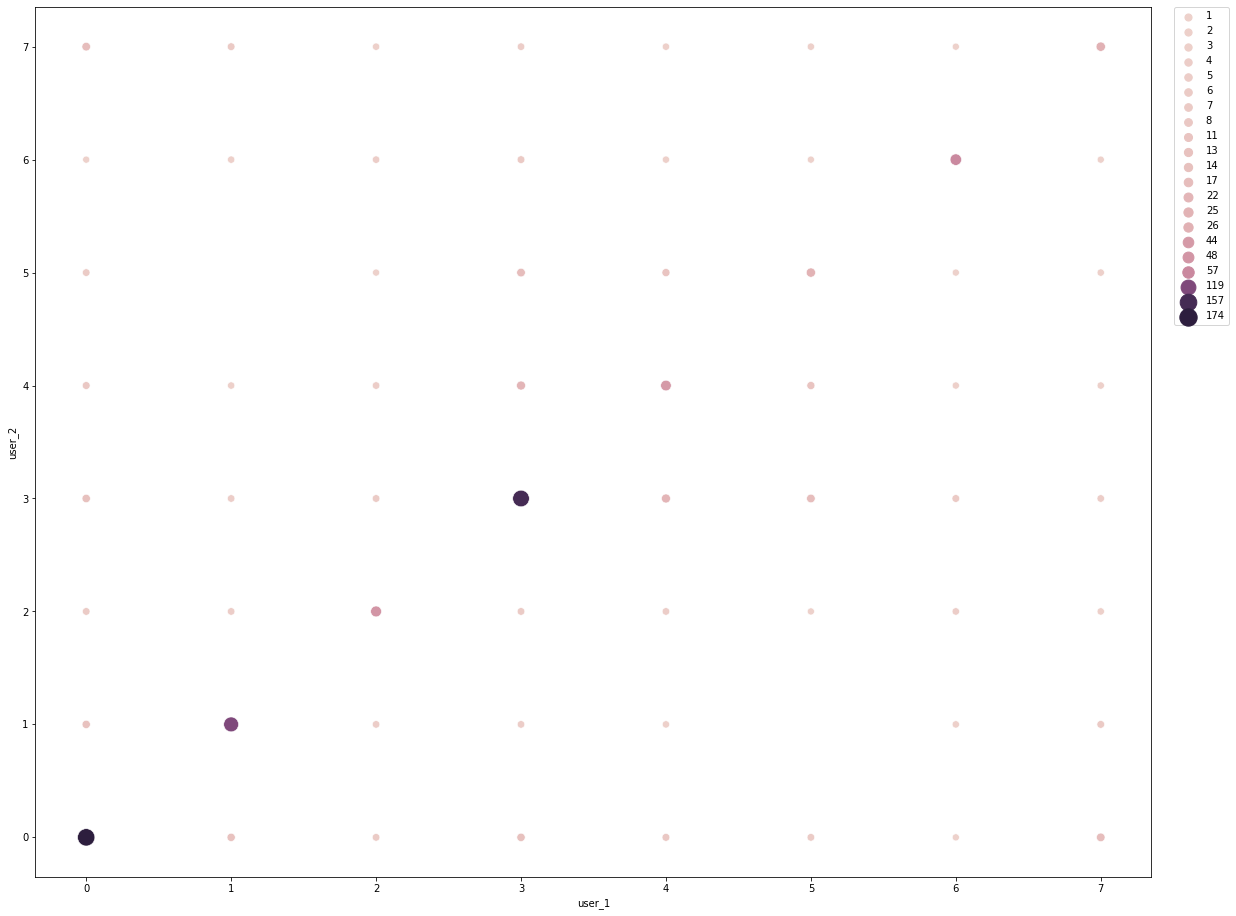

In [65]:
plt.figure(figsize=(20,16))


g=sns.scatterplot(data=df_match, x="user_1", y="user_2", hue='match', size="match",
    sizes=(50, 300),legend="full")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



## Algoritmos de clustering

### Hacemos un one hot encoder sobre la feature artista

In [66]:
data_encoded = pd.get_dummies(df_origen, columns = ['artista'])
data_encoded

,user_id,artista_0,artista_1,artista_2,artista_3,artista_4,artista_5,artista_6,artista_7,artista_8,...,artista_448,artista_449,artista_450,artista_451,artista_452,artista_453,artista_454,artista_455,artista_456,artista_457
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
584,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
df4 = data_encoded.groupby(['user_id'])[ data_encoded.columns[1:].values].sum()
df4=df4.reset_index()

In [68]:
df4

,user_id,artista_0,artista_1,artista_2,artista_3,artista_4,artista_5,artista_6,artista_7,artista_8,...,artista_448,artista_449,artista_450,artista_451,artista_452,artista_453,artista_454,artista_455,artista_456,artista_457
0,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,1
1,1,0,0,0,1,1,0,0,1,0,...,1,0,1,0,1,1,0,0,0,2
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,3,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,1,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
7,7,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


Aplicacion del modelo

In [69]:
X=df4.iloc[:,1:]
y=df4.iloc[:,0]

In [70]:
X

,artista_0,artista_1,artista_2,artista_3,artista_4,artista_5,artista_6,artista_7,artista_8,artista_9,...,artista_448,artista_449,artista_450,artista_451,artista_452,artista_453,artista_454,artista_455,artista_456,artista_457
0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,1,0,1,1
1,0,0,0,1,1,0,0,1,0,0,...,1,0,1,0,1,1,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


k Means 

Para este algoritmo es necesario evaluar el datafrme previamente para estimar a priori un valor adecuado de clusters para la división

In [71]:
kmeans_1 = KMeans(n_clusters=3)

3. Entrenamos los modelos con los datos

In [72]:
kmeans_1.fit(X)


KMeans(n_clusters=3)

Luego de entrenar los modelos, podemos consultar las etiquetas que se le asignó a cada instancia y el lugar de los centroides.

In [73]:
etiquetas_1 = kmeans_1.labels_
#print(etiquetas_1.shape)
etiquetas_1

array([2, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [74]:
cluster_map = pd.DataFrame()
cluster_map['user'] = y
cluster_map['cluster_KMeans'] = kmeans_1.labels_

In [75]:
cluster_map

,user,cluster_KMeans
0,0,2
1,1,0
2,2,0
3,3,1
4,4,0
5,5,0
6,6,0
7,7,0


# Grafo 
Este enfoque complementario al anterior analiza las relaciones desde el punto de vista de la red en sí. Es decir se puede, a partir de métricas evaluar si la red es una red bien interconectada o es una red pobre en conexiones. U otras métricas que indique qué nodos (usuarios) son los que más se encuentran en el camino de conexiones de los demás pares de nodos en la red; que a los fines de una implementación de red re recomendación son éstos nodos los que generan futuras conexiones entre nodos que antes no lo estaban.

In [76]:
import networkx as nx

In [77]:
df_relations=df_match[df_match['user_1']<df_match['user_2']]
df_relations.reset_index(inplace=True)

In [78]:
df_relations

,index,user_1,user_2,match
0,1,0,1,13
1,2,0,2,6
2,3,0,3,14
3,4,0,4,8
4,5,0,5,6
5,6,0,6,1
6,7,0,7,17
7,10,1,2,5
8,11,1,3,5
9,12,1,4,3


In [79]:
G = nx.from_pandas_edgelist(
    df_relations,
    source='user_1',
    target='user_2',
    #edge_labels={(source, target): match}
    #edge_key= "my_edge_key",
    #edge_attr=['match'],
    #create_using=nx.MultiGraph(),
)

In [80]:
G_weighted = nx.Graph()

In [81]:
for i in range(0, len(df_relations)):
  G_weighted.add_edge(df_relations.iloc[i,1],  df_relations.iloc[i,2],   weight=df_relations.iloc[i,3])
  

In [82]:
df_relations.iloc[:,3].describe()


count    27.000000
mean      6.629630
std       5.548029
min       1.000000
25%       3.000000
50%       5.000000
75%       7.500000
max      22.000000
Name: match, dtype: float64

In [83]:
elarge = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if d['weight'] >3 ]
emedium = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if (d['weight'] >=2 and d['weight'] <3) ]
esmall = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if d['weight'] <2]
plt.figure(figsize=(20,20))
pos = nx.circular_layout(G_weighted)  # positions for all nodes

<Figure size 1440x1440 with 0 Axes>

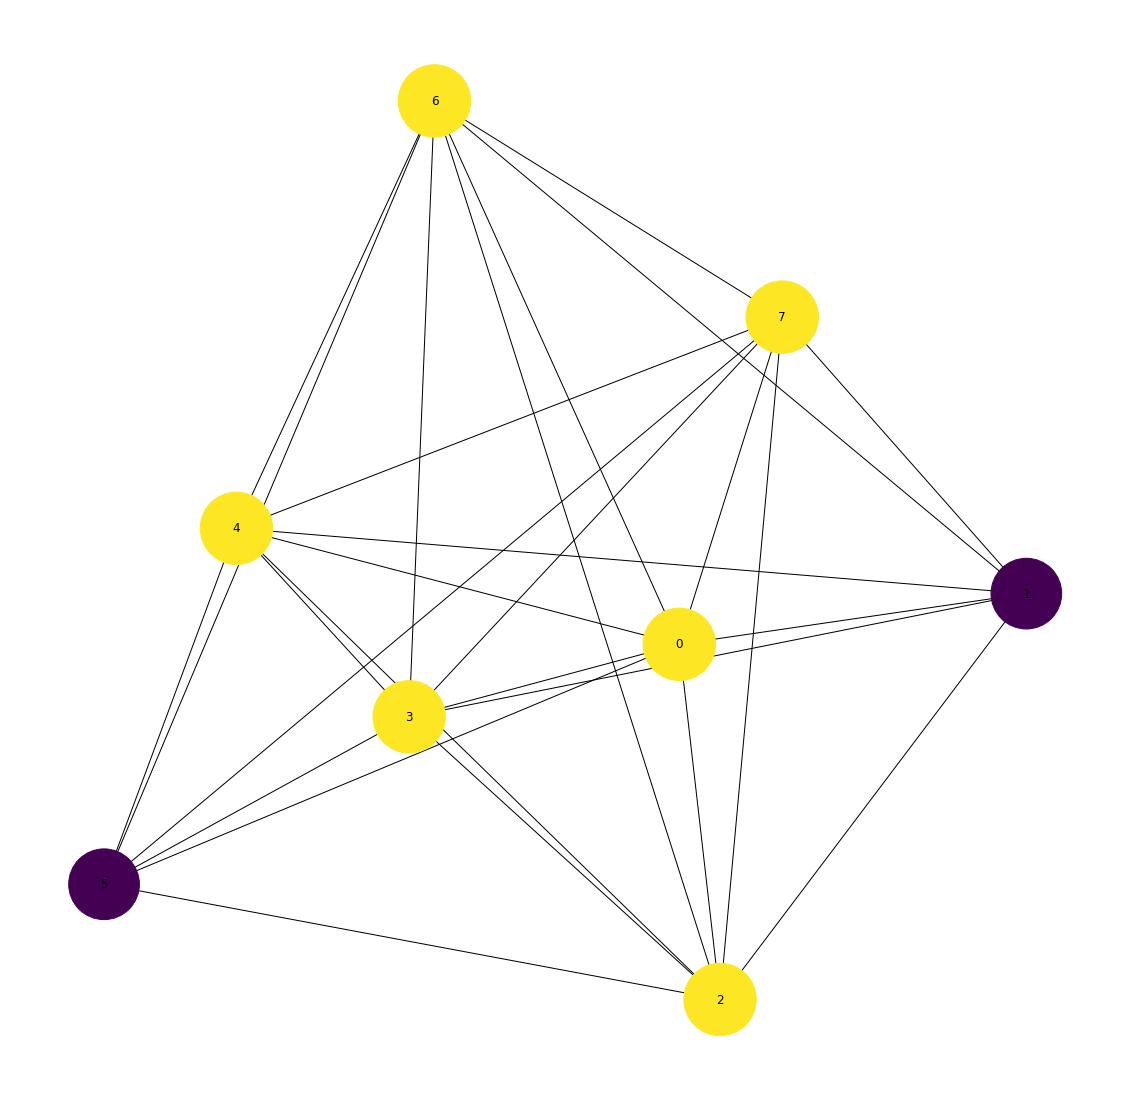

In [87]:
pos = nx.spring_layout(G_weighted,threshold=0.0001,k=0.92,dim=2,scale=.0005)
betCent = nx.betweenness_centrality(G_weighted, normalized=True, endpoints=True)
node_color = [20000.0 * G_weighted.degree(v) for v in G_weighted]
node_size =  [v*v * 80000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G_weighted, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off');

En la gráfica el color de los nodos varía con la centralidad de intermediación y el tamaño con grado. Ambas métricas definidas a continuación

In [ ]:
pos = nx.spring_layout(G_weighted.degree)
pos

{(0, 7): array([ 0.15580625, -0.98119907]),
 (1, 6): array([-0.95288875, -0.17315082]),
 (2, 7): array([1.        , 0.17824182]),
 (3, 7): array([ 0.88513001, -0.68490673]),
 (4, 7): array([-0.15529775,  0.97475315]),
 (5, 6): array([0.63213922, 0.96647243]),
 (6, 7): array([-0.88325656,  0.5997975 ]),
 (7, 7): array([-0.68163244, -0.88000827])}

# Algunas métricas

Promedio de grado de nodo en la red 

In [ ]:
nx.average_clustering(G_weighted) 

0.9642857142857143

Centralidad de grado número de aristas o lazos que posee un nodo con los demás.


In [ ]:
nx.degree_centrality(G_weighted)

{0: 1.0,
 1: 0.8571428571428571,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 0.8571428571428571,
 6: 1.0,
 7: 1.0}

Centralidad de intermediación o simplemente intermediación (en inglés, betweenness) es una medida de centralidad que cuantifica la frecuencia o el número de veces que un nodo se encuentra entre las geodésicas o caminos más cortos de otros actores

In [ ]:
nx.betweenness_centrality(G_weighted)

{0: 0.007936507936507936,
 1: 0.0,
 2: 0.007936507936507936,
 3: 0.007936507936507936,
 4: 0.007936507936507936,
 5: 0.0,
 6: 0.007936507936507936,
 7: 0.007936507936507936}